In [1]:
# Numerical/scientific computing packages.
import numpy as np
import scipy
import copy
import pandas as pd
import seaborn as sns
import csv

# Machine learning package.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

# Useful for saving our models.
import pickle

# Plotting packages.
import matplotlib
import matplotlib.pyplot as plt

print('Finished successfully loading packages')

Finished successfully loading packages


In [5]:
import random
random.seed(18618637)

lda_df = pd.read_csv('reducedDataSets/lda_reduced.csv')
lda_df = lda_df.drop("Unnamed: 0", axis=1)
lda_df.reset_index()
lda_df.head()

,popularity_stand,danceability_stand,instrumentalness_stand,loudness_stand,speechiness_stand,valence_stand,mode_Major,key_A,key_E,genre_label
0,-1.108003,0.524878,1.875809,0.638132,-0.185322,1.225073,0,0,0,5
1,-0.850633,0.356933,2.361357,0.339248,-0.627258,0.302431,0,0,0,5
2,-1.043661,0.345737,-0.521812,0.732892,-0.582867,-0.498812,1,0,0,5
3,-0.657606,1.207853,-0.550300,0.752201,1.434452,-0.753752,1,0,0,5
4,-0.786291,0.446504,2.235361,0.465324,-0.515787,-0.539278,1,0,0,5


In [15]:
X = lda_df.drop("genre_label", axis=1)
y = lda_df["genre_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=18618637)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

In [16]:
# validate that we don't have data leakage
y_test_counts = y_test.value_counts()
y_test_counts

genre_label
4    1000
2    1000
8    1000
3    1000
7    1000
1    1000
5    1000
0    1000
6    1000
9    1000
Name: count, dtype: int64

In [18]:
y_train_counts = y_train_final.value_counts()
y_train_counts

genre_label
2    3000
8    3000
7    3000
0    3000
1    3000
5    3000
9    3000
3    3000
4    3000
6    3000
Name: count, dtype: int64

In [28]:
# Logistic Regression
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

model_lr = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=18618637)

# 10-fold cross-validation.
# hyperparameters are tuned using the validation dataset
k = 10
splitter = model_selection.KFold(k)
# Compute cross-validation scores.
cv_scores = model_selection.cross_val_score(model_lr, X_train, y_train, cv = splitter)

# Just computed the cross validation scores 
print("Model CV score = ", np.mean(cv_scores))
# Train your logistic regression model_lr
model_lr.fit(X_train, y_train)
print("Test set score: {:.2f}".format(model_lr.score(X_test, y_test)))

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

Model CV score =  0.489275
Test set score: 0.50


0.8800187555555556

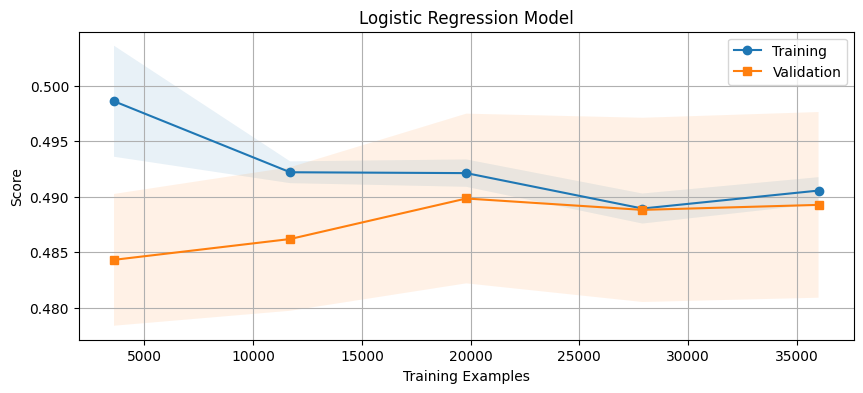

In [29]:
def graph_learning_curve(model, X_train, y_train, splitter, title="N/A"):
    fig, ax = plt.subplots(figsize=(10, 4))
    
    train_sizes, train_scores, test_scores = model_selection.learning_curve(model, X_train, y_train, cv=splitter)
    
    # Compute means and std to reflect the stability of the models
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax.set_title('{} Model'.format(title))
    ax.plot(train_sizes, train_scores_mean, 'o-', label='Training')
    ax.plot(train_sizes, test_scores_mean, 's-', label='Validation')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.grid()
    ax.legend()
    
    plt.show()

graph_learning_curve(model_lr, X_train, y_train, splitter, "Logistic Regression")

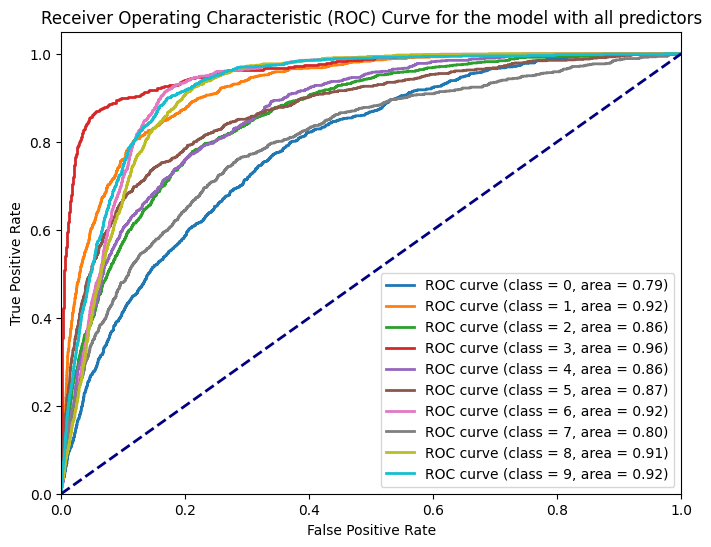

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Compute predicted probabilities for each class
predicted_probabilities = model_lr.predict_proba(X_test)

def graph_auc_curve_multiclass(model, predicted_probabilities, true_labels, title="all predictors"):
    plt.figure(figsize=(8, 6))
    # Calculate ROC curve for each class
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i], predicted_probabilities[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (class = {0}, area = {1:0.2f})'.format(lb.classes_[i], auc_score))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for the model with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_multiclass(model_lr, predicted_probabilities, y_test)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)
print("Validation score: ", roc_auc_score(y_val, y_pred, multi_class='ovr'))

0.9989649111111112

In [25]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [26]:
y_pred = dt.predict_proba(X_train)
auc = roc_auc_score(y_train, y_pred, multi_class='ovr')
print('train:', auc)

y_pred = dt.predict_proba(X_val)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
print('val:', auc)

train: 0.7658753229166667
val: 0.7630446999999999


In [27]:
graph_auc_curve_multiclass(dt, predicted_probabilities, y_test)

NameError: name 'dv' is not defined